In [1]:
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import *

In [2]:
no_dir = './brain_tumor_dataset/no'
yes_dir = './brain_tumor_dataset/yes'

In [3]:
img_to_array(load_img(os.path.join(no_dir , os.listdir(no_dir)[5]))).shape

(217, 232, 3)

In [5]:
dst = pd.DataFrame()
dst['answer'] = ['1'] * len(os.listdir(yes_dir)) + ['0'] * len(os.listdir(no_dir))

#sns.countplot(x='answer', data=dst)

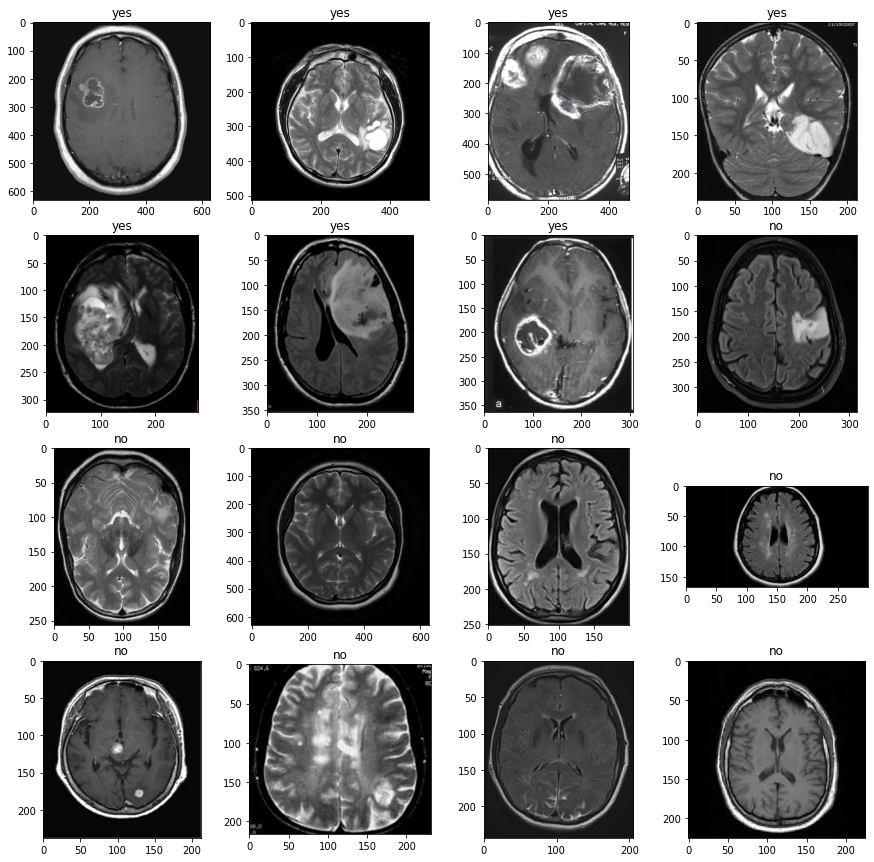

In [6]:
plt.figure(figsize=(15, 15))
plt.subplot(4, 4, 1)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[0])))
plt.title('yes')
plt.subplot(4, 4, 2)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[1])))
plt.title('yes')

plt.subplot(4, 4, 3)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[2])))
plt.title('yes')

plt.subplot(4, 4, 4)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[3])))
plt.title('yes')

plt.subplot(4, 4, 5)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[4])))
plt.title('yes')

plt.subplot(4, 4, 6)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[5])))
plt.title('yes')

plt.subplot(4, 4, 7)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[6])))
plt.title('yes')

plt.subplot(4, 4, 8)
plt.imshow(load_img(os.path.join(yes_dir , os.listdir(yes_dir)[7])))
plt.title('no')

plt.subplot(4, 4, 9)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[0])))
plt.title('no')
plt.subplot(4, 4, 10)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[1])))
plt.title('no')

plt.subplot(4, 4, 11)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[2])))
plt.title('no')

plt.subplot(4, 4, 12)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[3])))
plt.title('no')

plt.subplot(4, 4, 13)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[4])))
plt.title('no')

plt.subplot(4, 4, 14)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[5])))
plt.title('no')

plt.subplot(4, 4, 15)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[6])))
plt.title('no')

plt.subplot(4, 4, 16)
plt.imshow(load_img(os.path.join(no_dir , os.listdir(no_dir)[7])))
plt.title('no')
plt.show()

In [7]:
base_dir = './brain_tumor_dataset/'

datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2
                            )

train_gen= datagen.flow_from_directory(base_dir,
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( base_dir,
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [10]:
from keras.models import *
from keras.layers import *

from keras.applications.vgg16 import VGG16

VGG = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224, 3)
)

VGG.trainable = False
model = Sequential()
model.add(VGG)
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])


history = model.fit(
    train_gen,
    epochs = 20,
    batch_size = 32,
    validation_data = val_gen
)

"""
plt.figure(figsize=(15, 15))

plt.subplot(2,2, 1)
sns.lineplot(data = history.history, x = range(20), y = 'val_accuracy')
sns.lineplot(data = history.history, x = range(20), y = 'accuracy')
plt.legend()

plt.subplot(2,2, 2)
sns.lineplot(data = history.history, x = range(20), y = 'val_loss')
sns.lineplot(data = history.history, x = range(20), y = 'loss')
plt.legend()
"""


2022-04-15 17:44:51.879770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 17:44:52.917275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-04-15 17:44:52.917330: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-15 17:44:52.949094: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

58900480/58889256 [==============================] - 7s 0us/step
Epoch 1/20
7/7 [==============================] - 33s 4s/step - loss: 0.6475 - accuracy: 0.6355 - val_loss: 0.9390 - val_accuracy: 0.6800
Epoch 2/20
7/7 [==============================] - 27s 4s/step - loss: 0.4890 - accuracy: 0.7685 - val_loss: 0.9878 - val_accuracy: 0.7000
Epoch 3/20
7/7 [==============================] - 28s 4s/step - loss: 0.4411 - accuracy: 0.7685 - val_loss: 0.5029 - val_accuracy: 0.8000
Epoch 4/20
7/7 [==============================] - 28s 4s/step - loss: 0.3773 - accuracy: 0.8571 - val_loss: 0.7019 - val_accuracy: 0.7000
Epoch 5/20
7/7 [==============================] - 28s 4s/step - loss: 0.3659 - accuracy: 0.8374 - val_loss: 0.4249 - val_accuracy: 0.8000
Epoch 6/20
7/7 [==============================] - 30s 4s/step - loss: 0.3291 - accuracy: 0.8768 - val_loss: 0.5201 - val_accuracy: 0.8200
Epoch 7/20
7/7 [==============================] - 31s 5s/step - loss: 0.2812 - accuracy: 0.8966 - val_loss:

AttributeError: module 'keras.optimizers' has no attribute 'RMSprop'

In [14]:
from keras import optimizers

VGG.trainable = True
set_trainable = False

for layer in VGG.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

from tensorflow.keras import optimizers

model.compile(
    optimizer = optimizers.RMSprop(learning_rate= 1e-5),
    loss = 'binary_crossentropy',
    metrics= ['accuracy']
)

history = model.fit(
    train_gen,
    batch_size = 20,
    epochs = 30,
    validation_data = val_gen
)

"""
plt.subplot(2,2, 3)
sns.lineplot(data = history.history, x = range(30), y = 'val_accuracy')
sns.lineplot(data = history.history, x = range(30), y = 'accuracy')
plt.legend()

plt.subplot(2,2, 4)
sns.lineplot(data = history.history, x = range(30), y = 'val_loss')
sns.lineplot(data = history.history, x = range(30), y = 'loss')
plt.legend()
"""

Epoch 1/30
7/7 [==============================] - 39s 6s/step - loss: 0.3529 - accuracy: 0.8325 - val_loss: 0.3979 - val_accuracy: 0.7800
Epoch 2/30
7/7 [==============================] - 40s 6s/step - loss: 0.3315 - accuracy: 0.8522 - val_loss: 0.4333 - val_accuracy: 0.8200
Epoch 3/30
7/7 [==============================] - 39s 6s/step - loss: 0.3174 - accuracy: 0.8719 - val_loss: 0.3239 - val_accuracy: 0.8000
Epoch 4/30
7/7 [==============================] - 38s 5s/step - loss: 0.3068 - accuracy: 0.8670 - val_loss: 0.3555 - val_accuracy: 0.8000
Epoch 5/30
7/7 [==============================] - 39s 5s/step - loss: 0.3247 - accuracy: 0.8522 - val_loss: 0.4111 - val_accuracy: 0.8400
Epoch 6/30
7/7 [==============================] - 38s 5s/step - loss: 0.3074 - accuracy: 0.8473 - val_loss: 0.3290 - val_accuracy: 0.8000
Epoch 7/30
7/7 [==============================] - 38s 6s/step - loss: 0.2738 - accuracy: 0.8867 - val_loss: 0.3518 - val_accuracy: 0.8400
Epoch 8/30
7/7 [==================

"\nplt.subplot(2,2, 3)\nsns.lineplot(data = history.history, x = range(30), y = 'val_accuracy')\nsns.lineplot(data = history.history, x = range(30), y = 'accuracy')\nplt.legend()\n\nplt.subplot(2,2, 4)\nsns.lineplot(data = history.history, x = range(30), y = 'val_loss')\nsns.lineplot(data = history.history, x = range(30), y = 'loss')\nplt.legend()\n"